In [1]:
import med_dataloader as med_dl
import os
import json

In [2]:
import shutil

try:
    shutil.rmtree("Test_Dataset_segmentation_TF")
except:
    pass

In [3]:
ds_dir = os.path.join(os.getcwd(), "Test_Dataset_segmentation")
CT_dir = os.path.join(ds_dir, "CT")
Labels_dir = os.path.join(ds_dir, "Labels")
output_file = f"{ds_dir}.json"

CT_paths = [os.path.join(ds_dir, "CT", x) for x in os.listdir(CT_dir)]
Labels_paths = [os.path.join(ds_dir, "Labels", x) for x in os.listdir(Labels_dir)]

ds_dict = {"CT": CT_paths,
           "Labels": Labels_paths,}

with open(output_file, "w") as f:
    json.dump(ds_dict, f, indent=2)

In [4]:
num_classes = 3

med_dl.generate_dataset(data_path=r"Test_Dataset_segmentation.json",
                        imgA_label="CT",
                        imgB_label="Labels",
                        img_size=[256, 256, 256],
                        is_B_categorical=True,
                        num_classes=num_classes,
                        norm_boundsA=None,
                        norm_boundsB=None,
                        use_3D=True,
                        patch_size=128,
                        patch_overlap=0.1
                        )

train_ds, valid_ds, test_ds = med_dl.get_dataset(data_dir=r"Test_Dataset_segmentation_TF",
                                                 percentages=[1,0,0],
                                                 batch_size=1,
                                                 train_augmentation=True,
                                                 random_crop_size=None,
                                                 random_rotate=False,
                                                 random_flip=False,
                                                 )


Caching decoded images in Test_Dataset_segmentation_TF\CT.cache...
24/3
Cached decoded images in Test_Dataset_segmentation_TF\CT.cache.
Caching decoded images in Test_Dataset_segmentation_TF\Labels.cache...
24/3
Cached decoded images in Test_Dataset_segmentation_TF\Labels.cache.


tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


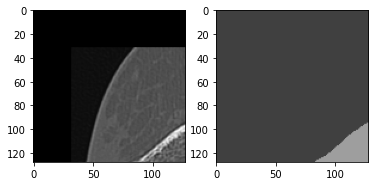

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


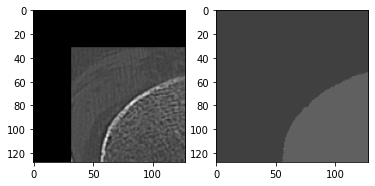

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


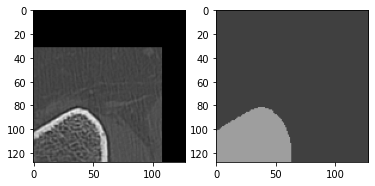

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


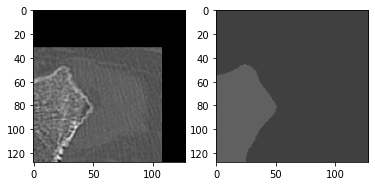

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


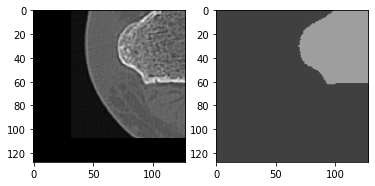

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


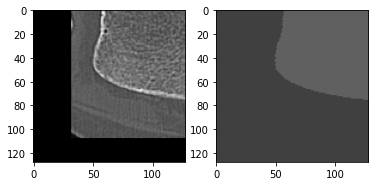

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


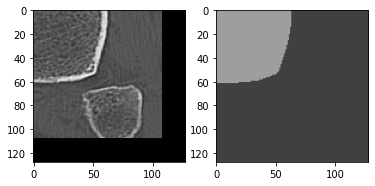

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


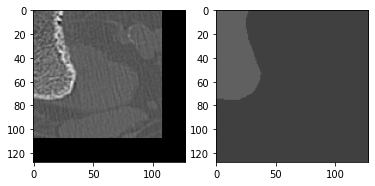

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


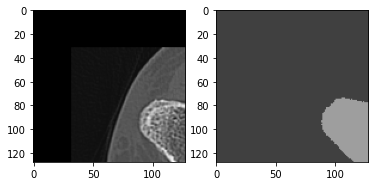

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


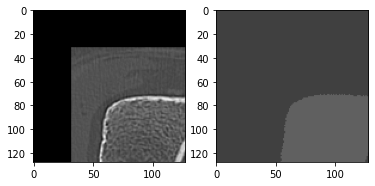

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


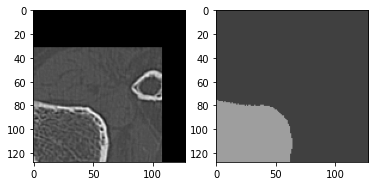

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


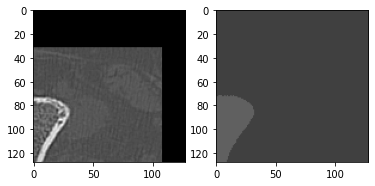

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


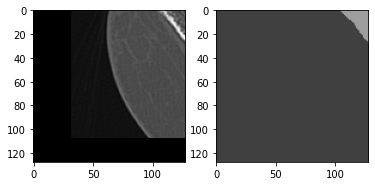

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


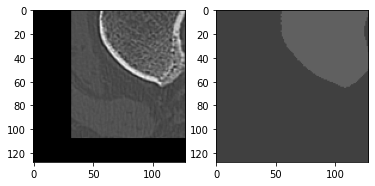

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


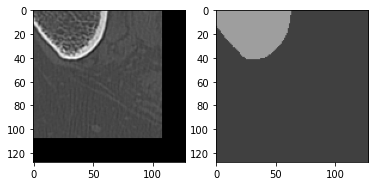

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


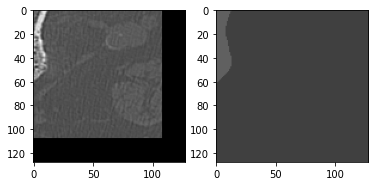

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


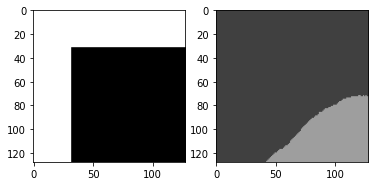

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


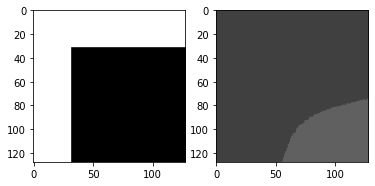

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


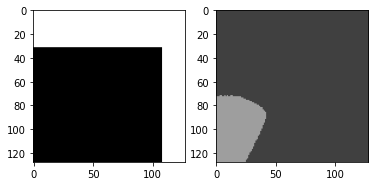

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


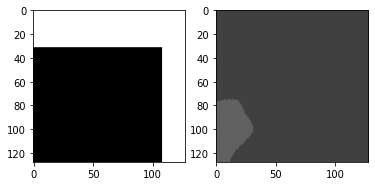

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


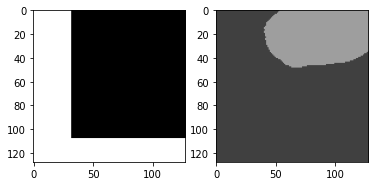

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


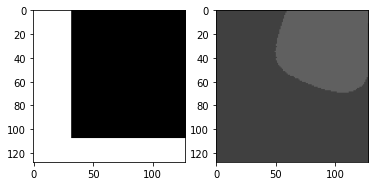

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


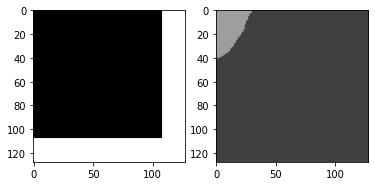

tf.Tensor([128 128 128   1], shape=(4,), dtype=int32)


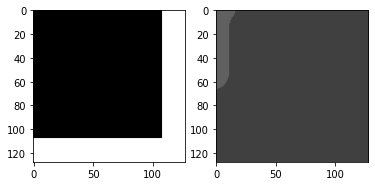

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
slice_index = 60

for batch in train_ds:
#for batch in train_ds.skip(192*0+70).take(30):
    volume_batch, label_batch = batch
    for volume, label in zip(volume_batch, label_batch):
        print(tf.shape(volume))
        plt.subplot(121)
        plt.imshow(volume[:,:,slice_index,0], cmap="gray")
        #plt.imshow(volume[:,:,0], cmap="gray")
        plt.subplot(122)
        for i in range(num_classes):
            plt.imshow(label[:,:,slice_index,i], cmap="gray", alpha=0.5)
            #plt.imshow(label[:,:,i], cmap="gray", alpha=0.5)
        plt.show()
    